In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.datasets import make_blobs
from sklearn.metrics import v_measure_score
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
import math
from collections import defaultdict
# We will be using the make_blobs method
# in order to generate our own data.

# Tóm tắt
Trong notebook này, chúng mình tiến hành cài đặt: Mean Shift Clustering (`class MyMeanShift`), Minibatch Mean Shift Clustering (`class MinibatchMeanshift`). Để hỗ trợ cho việc truy vết, mình cài đặt cấu trúc dữ liệu DSU (`class DisjointSetUnion`). 

## Class `DisjointSetUnioin`

In [2]:
class DisjointSetUnion:
    def __init__(self, n) -> None:
        self.f = np.full((n), -1)
        self.data = [[i] for i in range (n)] 
    
    def root(self, u):
        if (self.f[u] < 0):
            return u
        return self.root(self.f[u])
    
    def sameroot (self, u, v):
        return self.root(self, u) == self.root(self, v)
    
    def merge (self, u, v):
        u = self.root(u) 
        v = self.root(v)
        if (u == v):
            return False 
        if (self.f[u] > self.f[v]) : 
            u, v = v, u 
        self.f[u] += self.f[v]
        self.f[v] = u 
        self.data[u] += self.data[v] 
        self.data[v] = []
        return True

In [3]:
def FlatKernel (x):
    if(x <= 1): return 1
    return 0

def GaussianKernel(x):
    return (1 / np.sqrt(2*math.pi))*(math.exp(-0.5 * x * x))

def Epanechnikov(x):
  return 3/4 * (1 - x**2)

def Tricube(x):
  return 70/81 * (1 - x ** 3) ** 3
  
class MyMeanshift:
    def __init__(self, data, bandwidth, max_iter=10000, eps=0.001, kernel=FlatKernel):
        self.data = data
        self._n_ = len(data)
        self.bandwidth = bandwidth
        self.centroidsOfPoint = self.data
        self.centroidsList = []
        self.max_iter = max_iter
        self.kernel = kernel
        self.eps = eps
        self.labels = np.zeros(self._n_)

    def Shift(self):  # Shift 1 lan
        new_centroids = self.centroidsOfPoint.copy()
        MSV = 0  # Biến để lưu độ dài tối đa của các vector meanshift, nếu < eps thì trả về False để dừng Shift
        for i in range(self._n_):
            x = self.centroidsOfPoint[i]
            numerator = np.zeros(x.shape)
            denominator = 0.0
            for y in self.centroidsOfPoint:
                if (np.linalg.norm(x - y) <= self.bandwidth):
                    coeff = self.kernel(
                        (np.linalg.norm(x - y)**2) / (self.bandwidth**2))
                    numerator += y * coeff
                    denominator += coeff
            new_centroid = numerator / denominator
            MSV = max(MSV, np.linalg.norm(new_centroid - x))
            new_centroids[i] = new_centroid
        
        # Gán bộ lại bộ centroids cũ và bỏ đi các điểm trùng nhau
        self.centroidsOfPoint = new_centroids
        return MSV >= self.eps

    def Process(self):  # Shift nhiều lần
        # Dùng khi đủ số lần Shift cho phép hoặc hàm Shift trả về False
        for step in range(self.max_iter):
            if not self.Shift():
                return

    def PostProcess(self):
        assert(self._n_ == len(self.centroidsOfPoint))
        dsu = DisjointSetUnion(len(self.centroidsOfPoint)) 
        for i in range(len(self.centroidsOfPoint)):
            for j in range(i):
                if (np.linalg.norm(self.centroidsOfPoint[i] - self.centroidsOfPoint[j]) <= self.bandwidth):
                    dsu.merge(i, j) 
        for i in range(self._n_):
            self.centroidsOfPoint[i] = self.centroidsOfPoint[dsu.root(i)] 
        self.centroidsList = [] 
        for i in range(self._n_):
            if (dsu.root(i) == i):
                self.centroidsList.append(self.centroidsOfPoint[i]) 
        for i in range (self._n_): 
            for j in range(len(self.centroidsList)) :
                if (self.centroidsList[j] == self.centroidsOfPoint[i]).all():
                    self.labels[i] = j 
                    break  
        return

    # Get answer
    def fit(self):
        self.Process()
        self.PostProcess()

In [4]:

class MinibatchMeanshift:
    def __init__(self, data, bandwidth, max_iter=10000, eps=0.001, kernel=FlatKernel, batchsize = 10):
        self.data = data
        self._n_ = len(data)
        self.bandwidth = bandwidth
        self.centroidsOfPoint = self.data
        self.centroidsList = []
        self.max_iter = max_iter
        self.kernel = kernel
        self.eps = eps
        self.batchsize = batchsize
        self.labels = np.zeros(self._n_)

    def Shift(self):  # Shift 1 lần
        # Ở mỗi lần shift, ta tiến hành chia nhỏ dữ liệu thành các batch, mỗi batch có độ lớn là batch_size 
        # Cách implement việc chia batch: 
        #     Sinh random một hoán vị n số tự nhiên đầu tiên
        #     Xử lí theo từng segment bằng 2 pointer 
        # Ví dụ: Nếu n = 6, batch_size = 2
        #     hoán vị = [3, 0, 4, 2, 1, 5]
        #     Vậy batch đầu tiên gồm các điểm dữ liệu [3, 0]
        #         batch thứ hai gồm các điểm dữ liệu [4, 2] 
        #         batch thứ ba gồm các điểm dữ liệu [1, 5]
        new_centroids = self.centroidsOfPoint.copy()
        self.permute = np.random.permutation(self._n_) 
        MSV = 0  
        leftptr = 0 
        rightptr = self.batchsize - 1
        while leftptr < self._n_:
            rightptr = min(rightptr, self._n_ - 1)
            for ii in range(leftptr, rightptr + 1):
                i = self.permute[ii]
                x = self.centroidsOfPoint[i]
                numerator = np.zeros(x.shape)
                denominator = 0.0
                for jj in range(leftptr, rightptr + 1):
                    j = self.permute[jj]
                    y = self.centroidsOfPoint[j]
                    if (np.linalg.norm(x - y) <= self.bandwidth):
                        coeff = self.kernel(
                            (np.linalg.norm(x - y)**2) / (self.bandwidth**2))
                        numerator += y * coeff
                        denominator += coeff
                new_centroid = numerator / denominator
                MSV = max(MSV, np.linalg.norm(new_centroid - x))
                new_centroids[i] = new_centroid
            leftptr = leftptr + self.batchsize 
            rightptr = rightptr + self.batchsize

        self.centroidsOfPoint = new_centroids
        return MSV >= self.eps

    def Process(self):  # Shift nhiều lần
        # Dùng khi đủ số lần Shift cho phép hoặc hàm Shift trả về False
        for step in range(self.max_iter):
            if not self.Shift():
                return

    def PostProcess(self):
        assert(self._n_ == len(self.centroidsOfPoint))
        dsu = DisjointSetUnion(len(self.centroidsOfPoint)) 
        for i in range(len(self.centroidsOfPoint)):
            for j in range(i):
                if (np.linalg.norm(self.centroidsOfPoint[i] - self.centroidsOfPoint[j]) <= self.bandwidth):
                    dsu.merge(i, j) 
        for i in range(self._n_):
            self.centroidsOfPoint[i] = self.centroidsOfPoint[dsu.root(i)] 
        self.centroidsList = [] 
        for i in range(self._n_):
            if (dsu.root(i) == i):
                self.centroidsList.append(self.centroidsOfPoint[i]) 
        for i in range (self._n_): 
            for j in range(len(self.centroidsList)) :
                if (self.centroidsList[j] == self.centroidsOfPoint[i]).all():
                    self.labels[i] = j 
                    break  
        return

    # Get answer
    def fit(self):
        self.Process()
        self.PostProcess()

# DEMO 
Sinh dữ liệu từ bộ sinh blobs của sklearn.

Sau đó tiến hành chạy 3 thuật toán: `MyMeanshift(kernel=FlatKernel)`, `MyMeanshift(kernel=GaussianKernel)`, `MinibatchMeanshift(kernel=FlatKernel)`. Mỗi thuật toán được chạy trên một số bandwidth. 

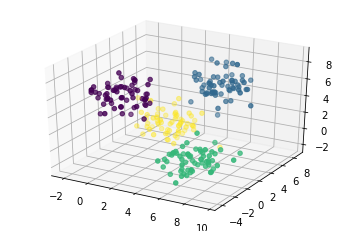

In [5]:
X, Y = make_blobs(250, 3, centers=[[0,0.1,5.3],[5.6,5.4,5.8],[6.5,-1.1,-0.2],[1.5,5.1,0.1]], cluster_std=1.13)
Y=np.asarray(Y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


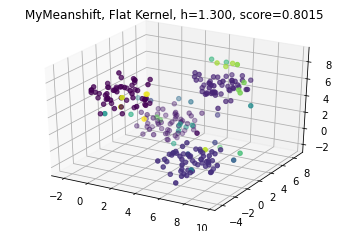

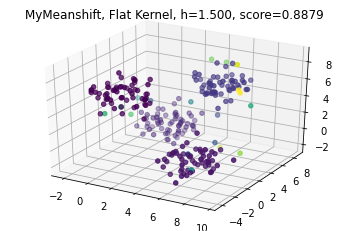

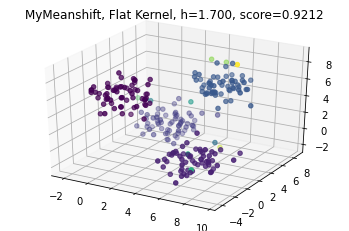

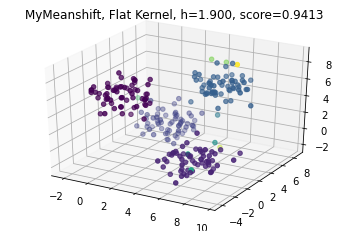

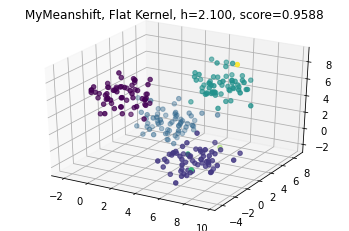

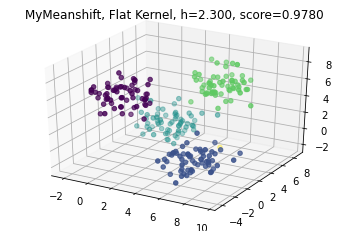

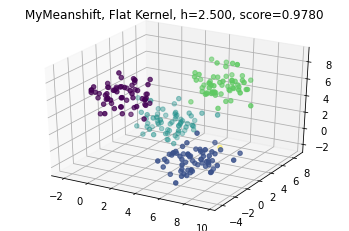

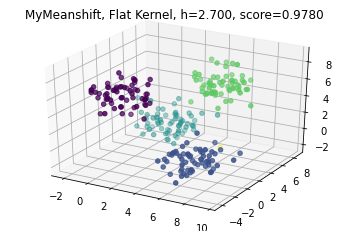

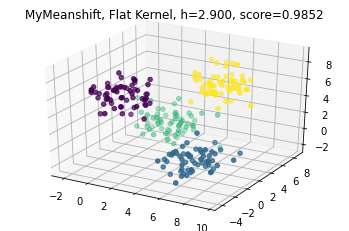

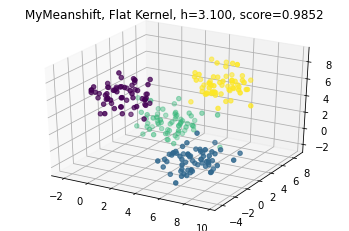

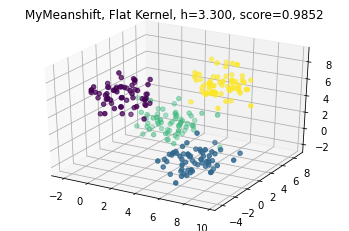

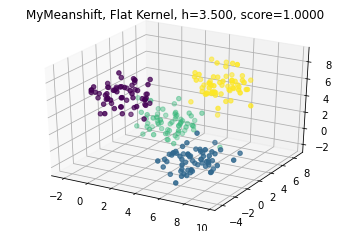

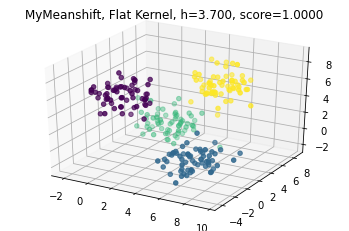

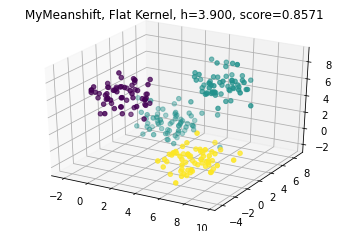

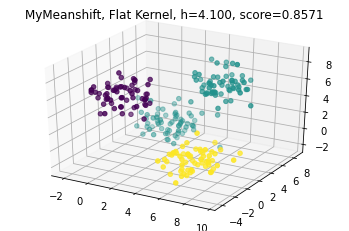

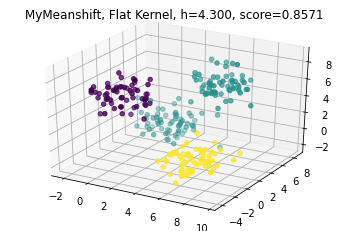

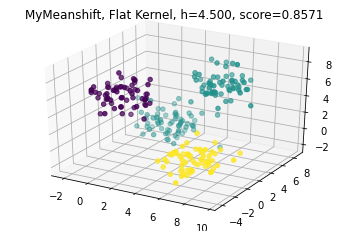

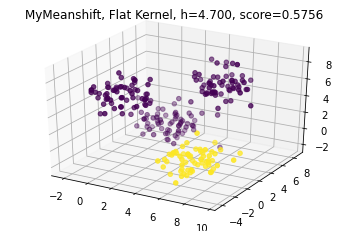

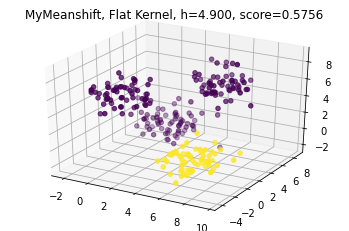

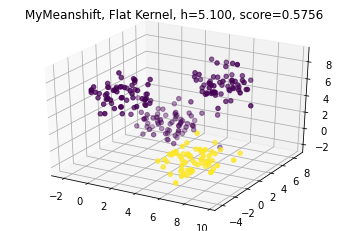

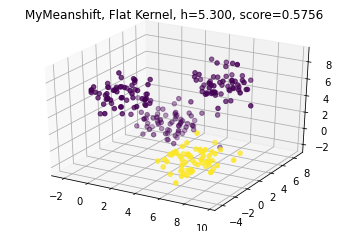

In [6]:
xh = np.linspace(1.3, 5.3, 21)

yh = xh.copy()

for (i, h) in enumerate(xh):
    ms = MyMeanshift(data=X, bandwidth=h, kernel=FlatKernel)
    ms.fit()
    ms_y = ms.labels
    vscore = v_measure_score(Y, ms_y)
    yh[i] = vscore 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("MyMeanshift, Flat Kernel, h="+"{:.3f}".format(ms.bandwidth)+", score=" + "{:.4f}".format(vscore))
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=ms_y)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


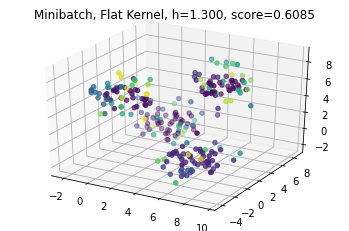

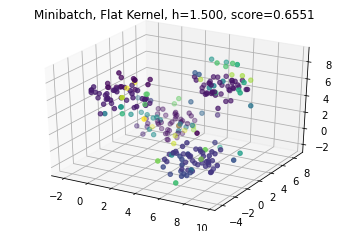

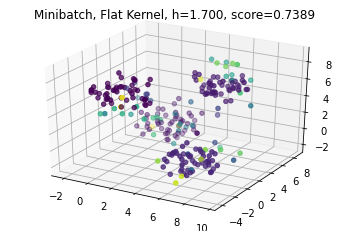

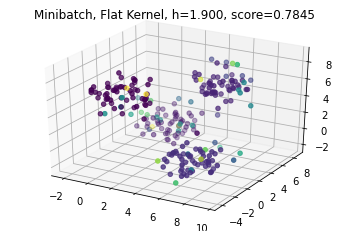

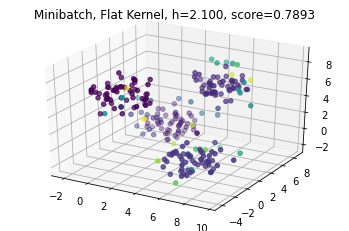

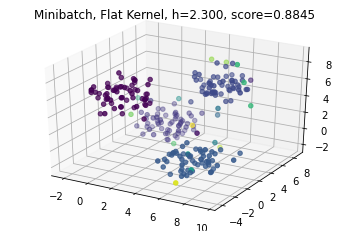

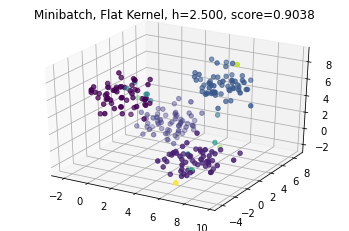

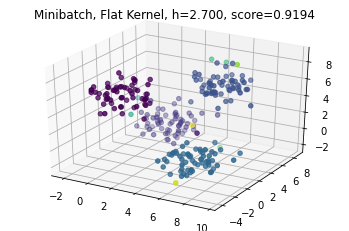

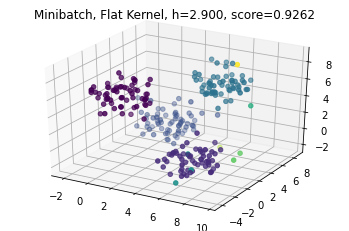

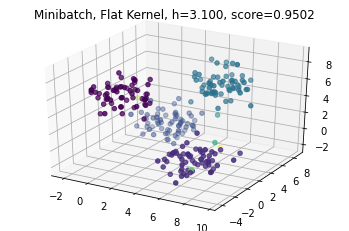

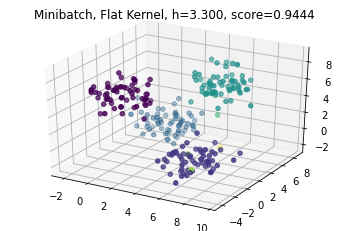

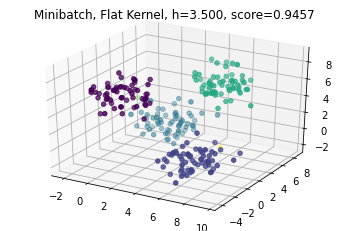

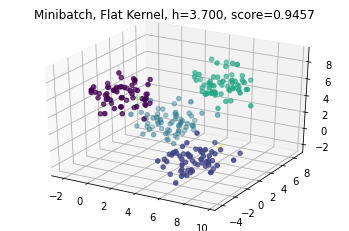

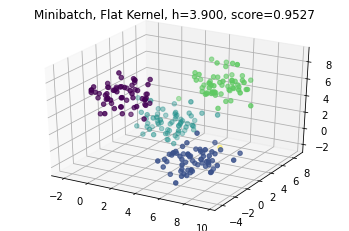

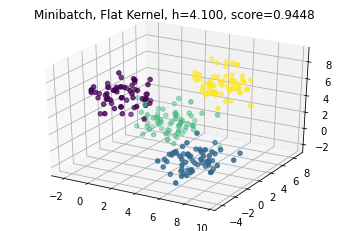

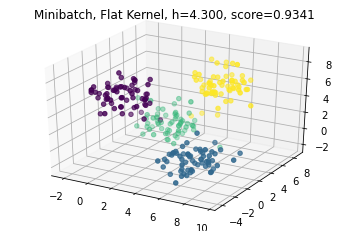

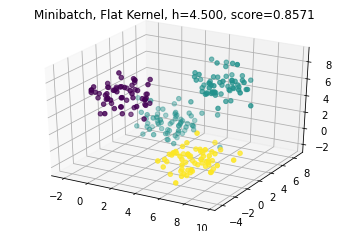

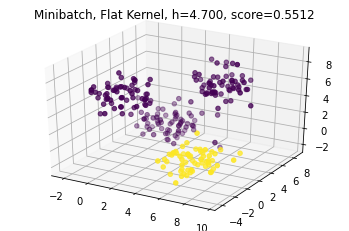

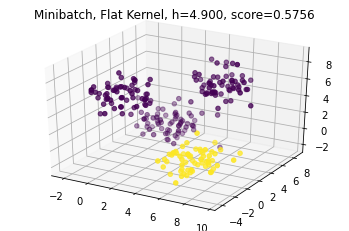

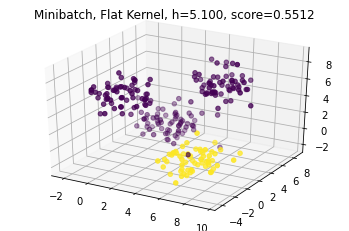

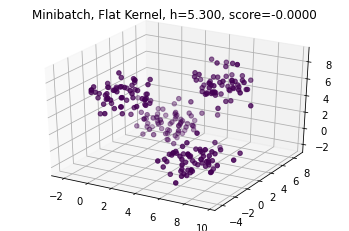

In [7]:
ymh = xh.copy()

for (i, h) in enumerate(xh):
    ms = MinibatchMeanshift(data=X, bandwidth=h, kernel=FlatKernel)
    ms.fit()
    ms_y = ms.labels
    vscore = v_measure_score(Y, ms_y)
    ymh[i] = vscore 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Minibatch, Flat Kernel, h="+"{:.3f}".format(ms.bandwidth)+", score=" + "{:.4f}".format(vscore))
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=ms_y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


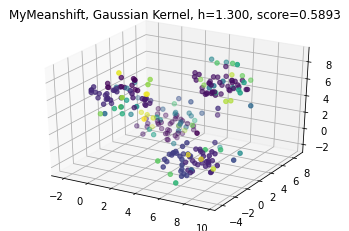

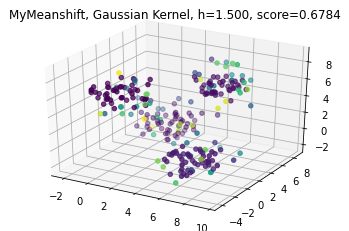

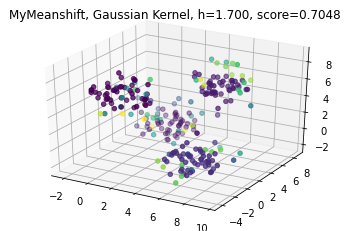

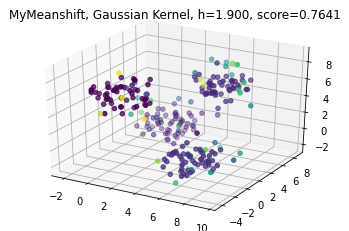

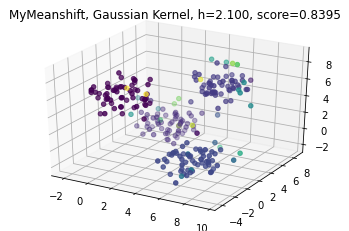

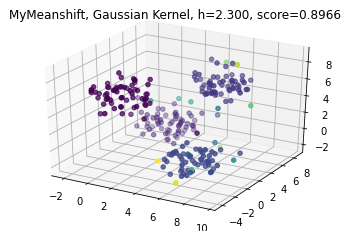

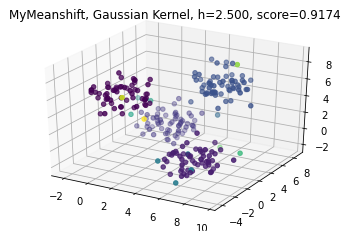

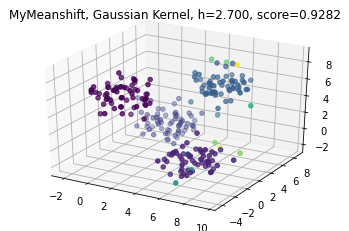

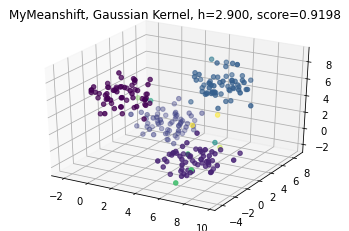

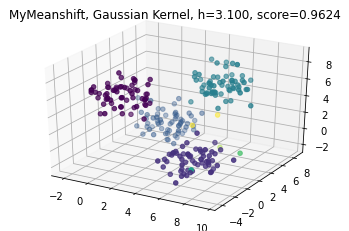

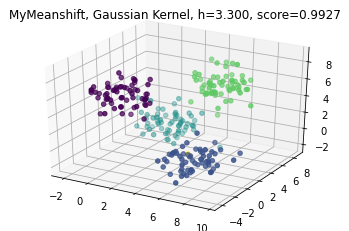

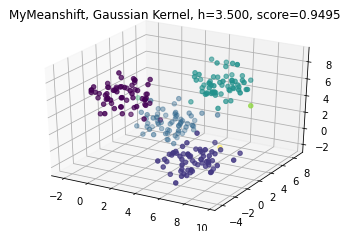

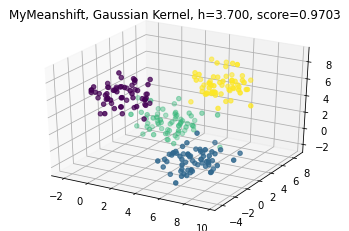

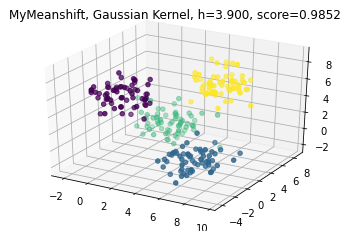

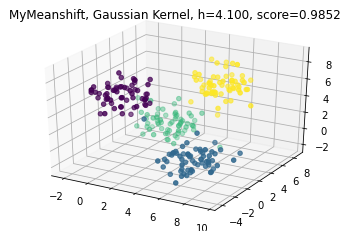

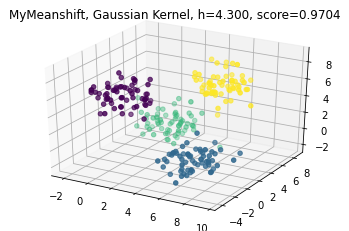

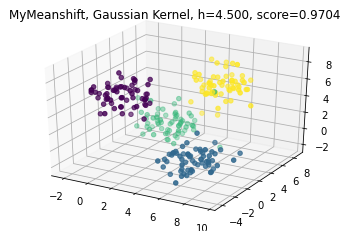

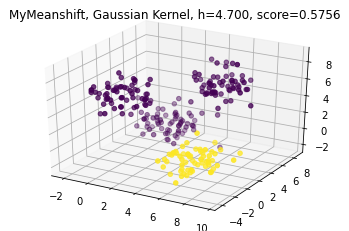

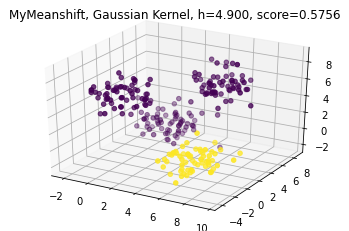

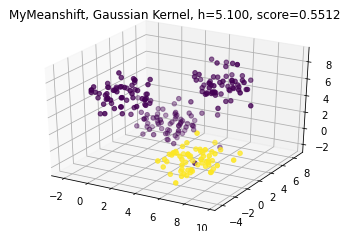

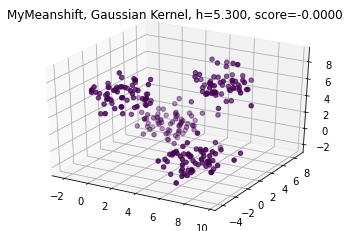

In [8]:
ygh = xh.copy()

for (i, h) in enumerate(xh):
    ms = MinibatchMeanshift(data=X, bandwidth=h, kernel=GaussianKernel)
    ms.fit()
    ms_y = ms.labels
    vscore = v_measure_score(Y, ms_y)
    ygh[i] = vscore 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("MyMeanshift, Gaussian Kernel, h="+"{:.3f}".format(ms.bandwidth)+", score=" + "{:.4f}".format(vscore))
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=ms_y)

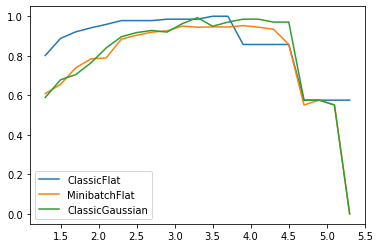

In [9]:
plt.plot(xh, yh, label='ClassicFlat')
plt.plot(xh, ymh, label='MinibatchFlat')
plt.plot(xh, ygh, label='ClassicGaussian')
plt.legend()
plt.show()